# Quanvolutional Neural Networks

This notebook is based on [this pennylane tutorial](https://pennylane.ai/qml/demos/tutorial_quanvolution/). I've been working with and learning more abouts neural networks, especifically quanvolutional neural networks based on hybrids quantum-classsical circuit models. Throughout this notebook, I'm going to comment and explain the main and most important parts of the algorithm, as well as, add another example with many more images in the training dataset to review and compare the difference in the model's performance.


### 1. Introduction
-   #### 1.1 Classical convolution
A Convolutional Neural Network (CNN) is a type of deep learning model primarily used for processing and analyzing visual data. It employs layers of convolutional filters to automatically learn spatial hierarchies of features from images, making it highly effective for tasks like image recognition and classification.

-   #### 1.2 Quantum convolution
A Quantum Convolutional Neural Network (QCNN) is a hybrid quantum-classical model that applies quantum gates to perform convolutional operations on quantum data, leveraging quantum mechanics to potentially enhance pattern recognition and feature extraction. It integrates quantum circuits into the convolutional layers, aiming to solve complex problems more efficiently, in principle, than classical CNNs.

### 2. General setup

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

2024-08-08 19:00:13.111478: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


-   #### 2.1 Setting of the main hyper-parameters of the model

In [2]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "data/"  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

Important to remark here, that the neural network only have one layer of parameters and an small dataset for train. This makes our model really small compared to real industry models and therefore we cannot expect huge results from it. However, it is a good example to learn.

-   #### 2.2 Loading of the MNIST dataset

In [3]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

print(train_images.shape)

(50, 28, 28, 1)


### 3. Quantum circuit as a convolution kernel

In this case, I will use one of the most interesting devices that pennylane offers in my opinion. It is "**lightning.gpu**", a fast state-vector qubit simulator utilizing **NVIDIA cuQuantum SDK** for GPU accelerated circuit simulation. And this will allow me to load and work with many more images in a fast way later on this notebook.

The 4-qubit quantum circuit which we are going to work consists of:
- a layer of local RY rotations to encode the classical input values;
- a random circuit of 'n_layers', one in this case;
- a final measurement in the computational basis, estimating 4 expectation values.

In [4]:
dev = qml.device("lightning.gpu", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

The next function defines the convolution scheme:

1.  the image is divided into squares of $2 \times 2$ pixels;
2.  each square is processed by the quantum circuit;
3.  the $4$ expectation values are mapped into $4$ different channels of
    a single output pixel.

This process split the input image in differents pieces of data to be able to be analized by our model and spot some key patterns presents in the images. These are the key features that are going to allow us achieve our task, that can be pattern recognition, image classification or other common machine learning tasks.

In [5]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

-    #### 3.1 Quantum pre-processing of the dataset

Since we are not going to train the quantum convolution layer, it is
more efficient to apply it as a \"pre-processing\" layer to all the
images of our dataset. Later an entirely classical model will be
directly trained and tested on the pre-processed dataset, avoiding
unnecessary repetitions of quantum computations.

The pre-processed images will be saved in the folder `SAVE_PATH`. Once
saved, they can be directly loaded by setting `PREPROCESS = False`,
otherwise the quantum convolution is evaluated at each run of the code.

In [6]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


Let us visualize the effect of the quantum convolution layer on a batch of samples:

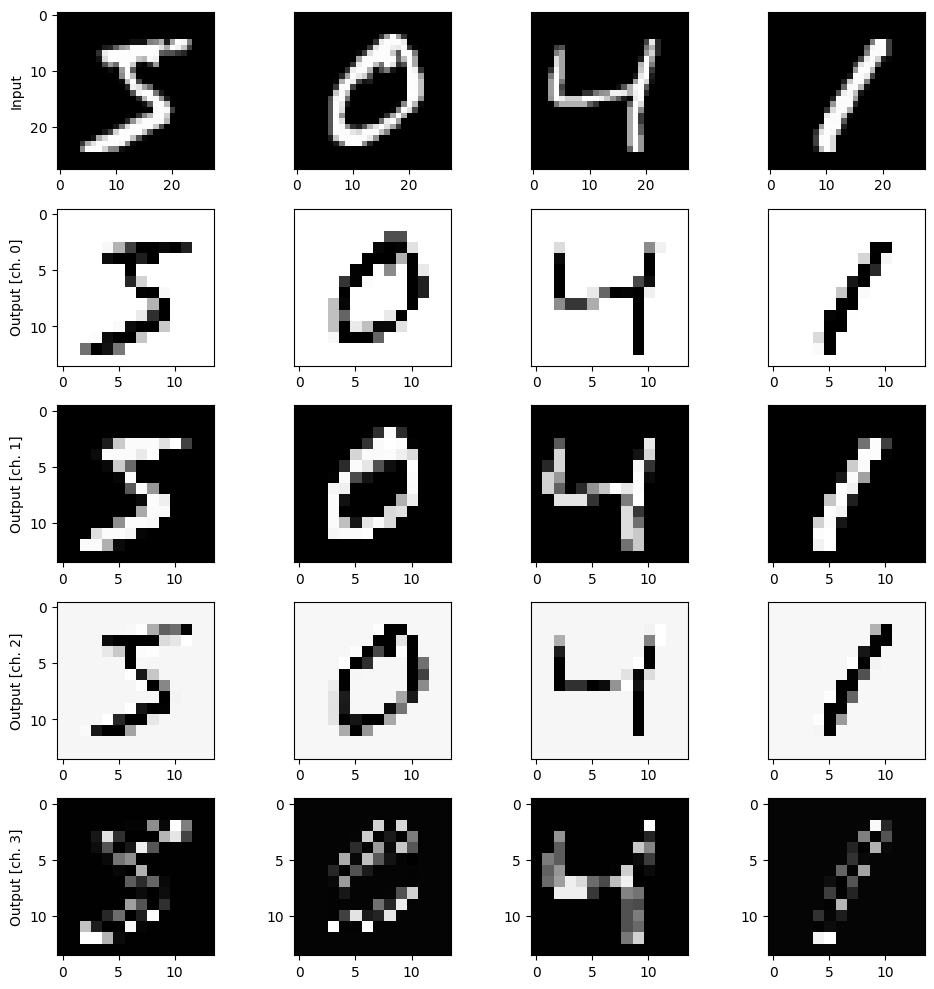

In [7]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

As we can see, in the convolution process the general shape of the number is maintained but the sharpness is greatly dissipated due to the quantum circuit through which they have passed.

### 4. Hybrid quantum-classical model

Here, we are going to train a classical model with the images that we have processed previously. The main task of this model is to classify accurately the 10 differents digits oh the MNIST dataset.

We use a very simple model: just a fully connected layer with 10 output nodes with a final softmax activation function.

The model is compiled with a stochastic-gradient-descent optimizer, and a cross-entropy loss function.

In [8]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

-   #### 4.1 Training

In [9]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30


I0000 00:00:1723136429.644493   10070 service.cc:145] XLA service 0x7421a0006440 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723136429.644513   10070 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
I0000 00:00:1723136429.926430   10070 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13/13 - 1s - 66ms/step - accuracy: 0.1600 - loss: 2.7844 - val_accuracy: 0.0333 - val_loss: 2.3231
Epoch 2/30
13/13 - 0s - 2ms/step - accuracy: 0.3600 - loss: 1.9094 - val_accuracy: 0.2000 - val_loss: 2.1524
Epoch 3/30
13/13 - 0s - 2ms/step - accuracy: 0.6800 - loss: 1.5538 - val_accuracy: 0.2667 - val_loss: 1.9260
Epoch 4/30
13/13 - 0s - 2ms/step - accuracy: 0.8000 - loss: 1.2130 - val_accuracy: 0.5000 - val_loss: 1.7626
Epoch 5/30
13/13 - 0s - 2ms/step - accuracy: 0.9600 - loss: 0.9915 - val_accuracy: 0.5667 - val_loss: 1.6511
Epoch 6/30
13/13 - 0s - 2ms/step - accuracy: 0.9600 - loss: 0.8135 - val_accuracy: 0.6333 - val_loss: 1.5569
Epoch 7/30
13/13 - 0s - 2ms/step - accuracy: 0.9600 - loss: 0.6769 - val_accuracy: 0.6667 - val_loss: 1.4748
Epoch 8/30
13/13 - 0s - 2ms/step - accuracy: 0.9600 - loss: 0.5700 - val_accuracy: 0.6667 - val_loss: 1.4101
Epoch 9/30
13/13 - 0s - 2ms/step - accuracy: 0.9800 - loss: 0.4854 - val_accuracy: 0.6667 - val_loss: 1.3589
Epoch 10/30
13/13 - 0s - 2ms/

In order to compare the results achievable with and without the quantum convolution layer, we initialize also a “classical” instance of the model that will be directly trained and validated with the raw MNIST images (i.e., without quantum pre-processing).

In [10]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - 52ms/step - accuracy: 0.1200 - loss: 2.3727 - val_accuracy: 0.3333 - val_loss: 2.0605
Epoch 2/30
13/13 - 0s - 2ms/step - accuracy: 0.2600 - loss: 1.9713 - val_accuracy: 0.4667 - val_loss: 1.9383
Epoch 3/30
13/13 - 0s - 2ms/step - accuracy: 0.6200 - loss: 1.6882 - val_accuracy: 0.5333 - val_loss: 1.8175
Epoch 4/30
13/13 - 0s - 2ms/step - accuracy: 0.7800 - loss: 1.4521 - val_accuracy: 0.6000 - val_loss: 1.7022
Epoch 5/30
13/13 - 0s - 2ms/step - accuracy: 0.8800 - loss: 1.2537 - val_accuracy: 0.7000 - val_loss: 1.6002
Epoch 6/30
13/13 - 0s - 2ms/step - accuracy: 0.9200 - loss: 1.0880 - val_accuracy: 0.7333 - val_loss: 1.5142
Epoch 7/30
13/13 - 0s - 2ms/step - accuracy: 0.9200 - loss: 0.9501 - val_accuracy: 0.7333 - val_loss: 1.4427
Epoch 8/30
13/13 - 0s - 2ms/step - accuracy: 0.9400 - loss: 0.8348 - val_accuracy: 0.7333 - val_loss: 1.3829
Epoch 9/30
13/13 - 0s - 2ms/step - accuracy: 0.9400 - loss: 0.7381 - val_accuracy: 0.7000 - val_loss: 1.3322
Epoch 10/30
13/13 

-   #### 4.2 Results

/tmp/ipykernel_6142/925943430.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


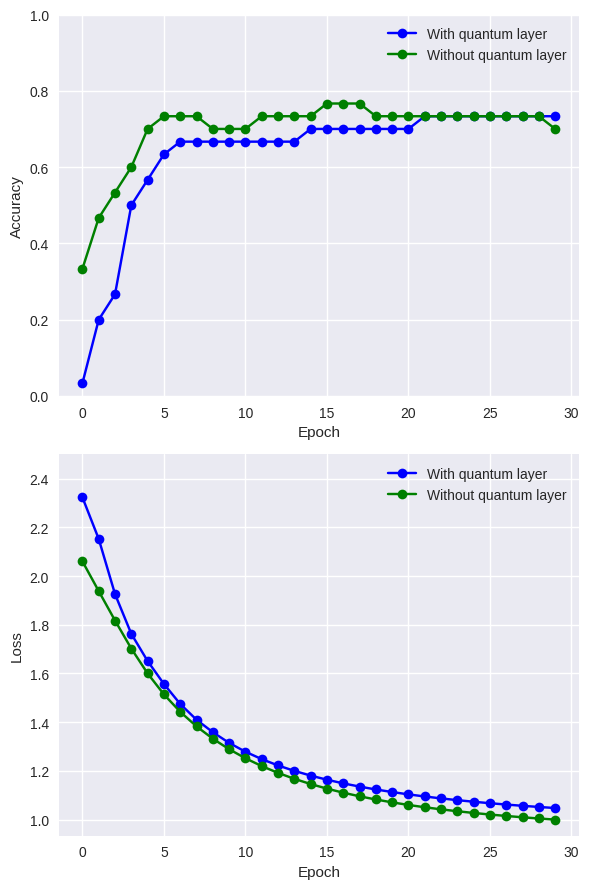

In [11]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

As we can observe, the results are not pretty good and the model without the quantum layer works better in general.

I'm going to replicate the same algorithm increasing the training dataset to 500 images, 10 times larger than the previous one.

**Will this improve the accuracy and performance of the model?**

In [19]:
n_train = 500    # Size of the train dataset
n_test = 100     # Size of the test dataset

SAVE_PATH = "data/500/"  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:
500/500        
Quantum pre-processing of test images:


In [20]:
q_model = MyModel()

q_history_500 = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
125/125 - 0s - 3ms/step - accuracy: 0.4200 - loss: 1.7277 - val_accuracy: 0.5900 - val_loss: 1.1790
Epoch 2/30
125/125 - 0s - 583us/step - accuracy: 0.7920 - loss: 0.8153 - val_accuracy: 0.7600 - val_loss: 0.8150
Epoch 3/30
125/125 - 0s - 589us/step - accuracy: 0.8500 - loss: 0.5780 - val_accuracy: 0.8100 - val_loss: 0.6770
Epoch 4/30
125/125 - 0s - 604us/step - accuracy: 0.8900 - loss: 0.4603 - val_accuracy: 0.8300 - val_loss: 0.5977
Epoch 5/30
125/125 - 0s - 580us/step - accuracy: 0.9140 - loss: 0.3827 - val_accuracy: 0.8500 - val_loss: 0.5426
Epoch 6/30
125/125 - 0s - 535us/step - accuracy: 0.9260 - loss: 0.3247 - val_accuracy: 0.8500 - val_loss: 0.5028
Epoch 7/30
125/125 - 0s - 519us/step - accuracy: 0.9320 - loss: 0.2785 - val_accuracy: 0.8700 - val_loss: 0.4746
Epoch 8/30
125/125 - 0s - 568us/step - accuracy: 0.9460 - loss: 0.2405 - val_accuracy: 0.8700 - val_loss: 0.4554
Epoch 9/30
125/125 - 0s - 567us/step - accuracy: 0.9540 - loss: 0.2088 - val_accuracy: 0.8700 - va

/tmp/ipykernel_6142/3271122804.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


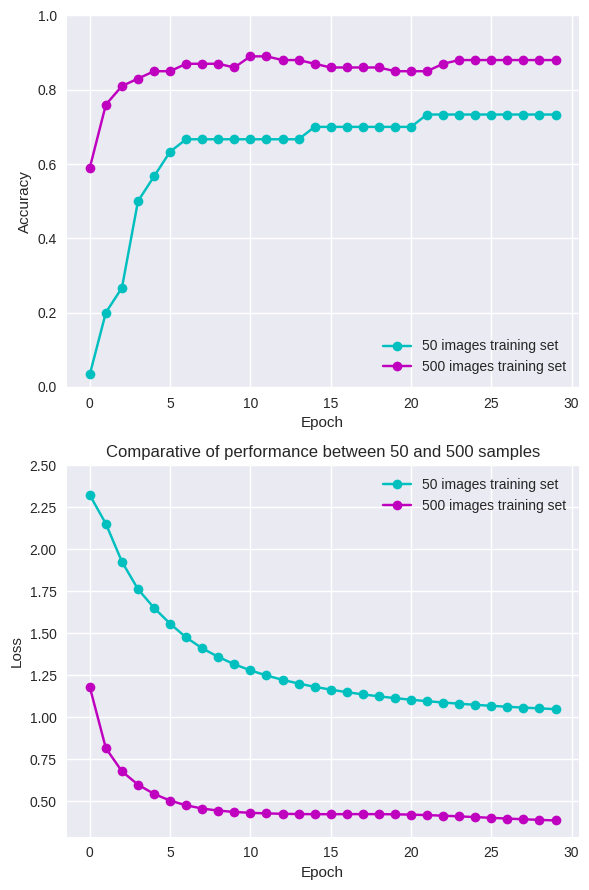

In [21]:
plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))
plt.title("Comparative of performance between 50 and 500 samples")

ax1.plot(q_history.history["val_accuracy"], "-oc", label="50 images training set")
ax1.plot(q_history_500.history["val_accuracy"], "-om", label="500 images training set")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-oc", label="50 images training set")
ax2.plot(q_history_500.history["val_loss"], "-om", label="500 images training set")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

Indeed, there is a clear **improvement** in the model's performance, although it is still far from perfect.